In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore') 
import os

In [48]:
train=pd.read_csv("E:/kaggle_imgs/H2/data/train_fold.csv")

In [49]:
import cv2
class ClassificationLoader:
    def __init__(self, image_paths, targets, resize, augmentations=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        image = cv2.imread(self.image_paths[item])
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        targets = self.targets[item]
        if self.augmentations:
            image = self.augmentations(image=image)["image"]
            
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return {
            "img":torch.tensor(image, dtype=torch.float),
            "tar":torch.tensor(targets, dtype=torch.long)
        }

In [50]:
from torch.utils.data.dataset import Dataset
class CutMix(Dataset):
    def __init__(self, dataset, num_class, num_mix=1, beta=1., prob=0.5):
        self.dataset = dataset
        self.num_class = num_class
        self.num_mix = num_mix
        self.beta = beta
        self.prob = prob
        
    def rand_bbox(self, size, lam):
        if len(size) == 4:
            W = size[2]
            H = size[3]
        elif len(size) == 3:
            W = size[1]
            H = size[2]
        else:
            raise Exception

        cut_rat = np.sqrt(1. - lam)
        cut_w = np.int(W * cut_rat)
        cut_h = np.int(H * cut_rat)

        # uniform
        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2

    def onehot(self,size, target):
        vec = torch.zeros(size, dtype=torch.float32)
        vec[target] = 1.
        return vec
    
    def __getitem__(self, index):
        data=self.dataset[index]
        img, lb = data["img"],data["tar"]
        lb_onehot = self.onehot(self.num_class, lb)

        for _ in range(self.num_mix):
            r = np.random.rand(1)
            if self.beta <= 0 or r > self.prob:
                continue

            # generate mixed sample
            lam = np.random.beta(self.beta, self.beta)
            rand_index = random.choice(range(len(self)))

            data=self.dataset[rand_index]
            img2, lb2 = data["img"],data["tar"]
            lb2_onehot = self.onehot(self.num_class, lb2)

            bbx1, bby1, bbx2, bby2 = self.rand_bbox(img.size(), lam)
            img[:, bbx1:bbx2, bby1:bby2] = img2[:, bbx1:bbx2, bby1:bby2]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img.size()[-1] * img.size()[-2]))
            lb_onehot = lb_onehot * lam + lb2_onehot * (1. - lam)

        return {
            "img":torch.tensor(img, dtype=torch.float),
            "tar":torch.tensor(lb_onehot, dtype=torch.long)
        }

    def __len__(self):
        return len(self.dataset)

In [51]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
import torchvision

def get_model_resnet50(classes):
    base_model = torchvision.models.resnet50(pretrained=True)
    num_ftrs = base_model.fc.in_features
    base_model.fc = nn.Linear(num_ftrs,classes, bias = True)
    return base_model

def get_model_effi_b4(classes):
    classes=classes
    base_model = EfficientNet.from_pretrained("efficientnet-b4")
    num_ftrs = base_model._fc.in_features
    base_model._fc = nn.Linear(num_ftrs,classes, bias = True)
    return base_model    

# EfficientNet-b4
class EffiNet(nn.Module):
    def __init__(self,classes):
        super(EffiNet, self).__init__()
        self.classes=classes
        self.base_model = EfficientNet.from_pretrained("efficientnet-b4")
        num_ftrs = self.base_model._fc.in_features
        self.base_model._fc = nn.Linear(num_ftrs,self.classes, bias = True)
        
    def forward(self, image):
        out = self.base_model(image)
        return out

# Resnet50
import torchvision
class Resnet50(nn.Module):
    def __init__(self,classes):
        super(Resnet50, self).__init__()
        self.classes=classes
        self.base_model = torchvision.models.resnet50(pretrained=True)
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_ftrs,self.classes, bias = True)
        
    def forward(self, image):
        out = self.base_model(image)
        return out       
# densenet
import torchvision
class Densenet(nn.Module):
    def __init__(self,classes):
        super(Densenet, self).__init__()
        self.classes=classes
        self.base_model = torchvision.models.densenet201(pretrained=True)
        num_ftrs = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Linear(num_ftrs,self.classes, bias = True)
        
    def forward(self, image):
        out = self.base_model(image)
        return out    
# EfficientNet-b7
class EffiNet7(nn.Module):
    def __init__(self,classes):
        super(EffiNet7, self).__init__()
        self.classes=classes
        self.base_model = EfficientNet.from_pretrained("efficientnet-b7")
        num_ftrs = self.base_model._fc.in_features
        self.base_model._fc = nn.Linear(num_ftrs,self.classes, bias = True)
        
    def forward(self, image):
        out = self.base_model(image)
        return out

In [52]:
import albumentations as A
from albumentations.pytorch import ToTensor
SIZE=224
import random

class Utils:
    def __init__():
        pass
    def get_aug(mode="train"):
        if mode=="Nor":
            aug=A.Compose([
                ToTensor(),
            ])
        elif mode =="train":
            print("train aug")
            mean = (0.485,0.456,0.406)
            std = (0.229,0.224,0.225)
            aug=A.Compose([
                A.Flip(),
                A.ShiftScaleRotate(rotate_limit=1.0, p=0.8),
                # Pixels
                A.OneOf([
                    A.IAAEmboss(p=1.0),
                    A.IAASharpen(p=1.0),
                    A.Blur(p=1.0),
                ], p=0.5),
                # Affine
                A.OneOf([
                    A.ElasticTransform(p=1.0),
                    A.IAAPiecewiseAffine(p=1.0)
                ], p=0.5),

                A.Normalize(mean=mean,std=std,max_pixel_value=255.0,always_apply=True),
            ])
        else:
            print("valid/test aug")
            mean = (0.485,0.456,0.406)
            std = (0.229,0.224,0.225)
            aug=A.Compose([
                A.Normalize(mean=mean,std=std,max_pixel_value=255.0,always_apply=True),
            ])

        return aug 
    def get_model(model_name, classes):
        if model_name=="effinet": return EffiNet(classes=classes)
        if model_name=="resnet": return Resnet50(classes=classes)    
        if model_name=="densenet": return Densenet(classes=classes)    
        if model_name=="effinet7": return EffiNet7(classes=classes)

In [53]:
#clcarwin / focal_loss_pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
#         if isinstance(alpha,(float,int,long)): self.alpha = torch.Tensor([alpha,1-alpha])
#         if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()
# My Focal Loss
class FocalLoss2(nn.Module):
    def __init__(self, gamma=2, eps=1e-7):
        super(FocalLoss2, self).__init__()
        self.gamma = gamma
        self.eps = eps
    def fl_onehot(self,index,classes,tar):
        y_onehot = torch.FloatTensor(index, classes).to("cuda")
        y_onehot.zero_()
        y_onehot.scatter_(1, tar, 1)
        return (y_onehot)        
    def forward(self, inputs, targets):
        y = self.fl_onehot(inputs.size()[0],inputs.size()[1],targets.view(-1,1))
        logit = F.softmax(inputs, dim=-1)
        logit = logit.clamp(self.eps, 1. - self.eps)

        loss = -1 * y * torch.log(logit) # cross entropy
        loss = loss * (1 - logit) ** self.gamma # focal loss

        return loss.mean()      
# My Focal Loss
class FocalLoss3(nn.Module):# for cutmix
    def __init__(self, gamma=2, eps=1e-7):
        super(FocalLoss3, self).__init__()
        self.gamma = gamma
        self.eps = eps
    def forward(self, inputs, targets):
        logit = F.softmax(inputs, dim=-1)
        logit = logit.clamp(self.eps, 1. - self.eps)

        loss = -1 * targets * torch.log(logit) # cross entropy
        loss = loss * (1 - logit) ** self.gamma # focal loss

        return loss.mean()  
import torch.nn.functional as F
class DenseCrossEntropy(nn.Module):
    def __init__(self):
        super(DenseCrossEntropy, self).__init__()
        
    def forward(self, logits, labels):
        logits = logits.float()
        labels = labels.float()
        
        logprobs = F.log_softmax(logits, dim=-1)
        
        loss = -labels * logprobs
        loss = loss.sum(-1)

        return loss.mean() 

In [102]:
import json
class History:
    def __init__(self,model_name):
        self.train_info=dict()
        self.valid_info=dict()
        self.model_name=model_name
        self.np_train_info=[]
        self.np_valid_info=[]
    def save_dict(self):
        tm=datetime.datetime.now().strftime("%m%d")
        json.dump(self.train_info,open(f"train_{tm}.json","w"))
        json.dump(self.valid_info,open(f"valid_{tm}.json","w"))
    def load_dict(self,tm="1019"):
        self.np_train_info=json.load(open(f"train_{tm}.json"))
        self.np_valid_info=json.load(open(f"valid_{tm}.json"))
    def initial_info(self,sel_pos):
        categories=["Acc","Loss","Labels","Preds"]
        for cat in categories:
            key=f"F{sel_pos}_{cat}"
            self.train_info[key]=[]
            self.valid_info[key]=[]
    def add_train_info(self,sel_pos, train_acc,train_loss,train_labels,train_preds,valid_acc,valid_loss,valid_labels,valid_preds):
        categories=["Acc","Loss","Labels","Preds"]
        key=f"F{sel_pos}_Acc"
        self.train_info[key].append(train_acc)
        key=f"F{sel_pos}_Loss"
        self.train_info[key].append(train_loss)
        key=f"F{sel_pos}_Acc"
        self.valid_info[key].append(valid_acc)
        key=f"F{sel_pos}_Loss"
        self.valid_info[key].append(valid_loss) 
        key=f"F{sel_pos}_Labels"
        self.valid_info[key].append(valid_labels) 
        key=f"F{sel_pos}_Preds"
        self.valid_info[key].append(valid_preds) 

In [55]:
## Engine
from sklearn.metrics import accuracy_score
class Engine:
    def __init__(self,model,optimizer,device,classes,weights=None):
        self.model=model
        self.optimizer=optimizer
        self.device=device
        self.classes=classes
        self.weights=weights
        
        if weights is None:
            self.criterion=nn.CrossEntropyLoss()
        else:
            class_weights = torch.FloatTensor(weights).cuda()
            self.criterion=nn.CrossEntropyLoss(class_weights)

#         self.criterion=DenseCrossEntropy()
#         self.criterion=FocalLoss2()
#         self.criterion=FocalLoss3()
        # self.criterion=nn.BCEWithLogitsLoss()
    
    def loss_fn(self,targets,outputs):
        return self.criterion(outputs,targets)
        
    def get_accuracy(self,labels,preds):
        total=labels.shape[0]
        if labels.shape[1]==1:
            p=np.uint8(preds>0.5)
            return np.uint8(labels==p).sum()/total
        else:
            preds=preds.argmax(1).reshape(-1,1)
            return np.uint8(labels==preds).sum()/total
    
    def train(self,data_loader):
        preds_for_acc = []
        labels_for_acc = []
        self.model.train()
        final_loss=0
        for data in data_loader:
            self.optimizer.zero_grad()
            inputs=data["img"].to(self.device)
            targets=data["tar"].to(self.device)
            outputs=self.model(inputs)
            loss=self.loss_fn(targets,outputs)
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()
            ## accuracy
            labels = targets.cpu().numpy().reshape(-1,1)
            preds = outputs.cpu().detach().numpy()
            if len(labels_for_acc)==0:
                labels_for_acc = labels
                preds_for_acc = preds
            else:
                labels_for_acc=np.vstack((labels_for_acc,labels))
                preds_for_acc=np.vstack((preds_for_acc,preds))
        accuracy = self.get_accuracy(labels_for_acc,preds_for_acc)
        return final_loss/len(data_loader),accuracy,labels_for_acc,preds_for_acc
    
    def validate(self,data_loader):
        preds_for_acc = []
        labels_for_acc = []
        self.model.eval()
        final_loss=0
        for data in data_loader:
            inputs=data["img"].to(self.device)
            targets=data["tar"].to(self.device)
            with torch.no_grad():
                outputs=self.model(inputs)
                loss=self.loss_fn(targets,outputs)
                final_loss += loss.item()
            ## accuracy
            labels = targets.cpu().numpy().reshape(-1,1)
            preds = outputs.cpu().detach().numpy()
            if len(labels_for_acc)==0:
                labels_for_acc = labels
                preds_for_acc = preds
            else:
                labels_for_acc=np.vstack((labels_for_acc,labels))
                preds_for_acc=np.vstack((preds_for_acc,preds))
        accuracy = self.get_accuracy(labels_for_acc,preds_for_acc)
        return final_loss/len(data_loader),accuracy,labels_for_acc,preds_for_acc
    
    def predict(self,data_loader):
        self.model.eval()
        final_predictions = []
        for data in data_loader:
            inputs=data["img"].to(self.device)
            predictions = self.model(inputs)
            predictions = predictions.cpu()
            final_predictions.append(predictions.detach().numpy())
        return final_predictions

In [57]:
bs_train=16
bs_valid=12

import datetime
def loop_train(fold, model_name,weights,sel_pos):
    history.initial_info(sel_pos)
    train_df=train[train.fold!=fold].reset_index(drop=True)
    valid_df=train[train.fold==fold].reset_index(drop=True)
    train_df["result"]=train_df["category"].apply(lambda x : x>0).astype(np.int)
    valid_df["result"]=valid_df["category"].apply(lambda x : x>0).astype(np.int)

    train_imgs=train_df.tar_path.values.tolist()
    train_aug=Utils.get_aug("train")
    train_tar=train_df.result.values
    train_dataset=ClassificationLoader(
        image_paths=train_imgs,targets=train_tar,resize=None,augmentations=train_aug
    )
#     CutMix_train_dataloader = CutMix(train_dataset, 
#                           num_class=4, 
#                           beta=1.0, 
#                           prob=0.999, 
#                           num_mix=1)
    CutMix_train_dataloader=train_dataset
    train_loader=torch.utils.data.DataLoader(
        CutMix_train_dataloader,batch_size=bs_train,num_workers=0,shuffle=True
    )
    
    valid_imgs=valid_df.tar_path.values.tolist()
    valid_aug=Utils.get_aug("valid")
    valid_tar=valid_df.result.values
    valid_dataset=ClassificationLoader(
        image_paths=valid_imgs,targets=valid_tar,resize=None,augmentations=valid_aug
    )
#     CutMix_valid_dataloader = CutMix(valid_dataset, 
#                           num_class=4, 
#                           beta=1.0, 
#                           prob=0, 
#                           num_mix=1)
    CutMix_valid_dataloader=valid_dataset
    valid_loader=torch.utils.data.DataLoader(
        CutMix_valid_dataloader,batch_size=bs_valid,num_workers=0,shuffle=False
    )
    
    # Model,Optimizer, scheduler, engine
    # model=Utils.get_model(model_name,classes=1)
    model = get_model_effi_b4(classes=2)
    
    device="cuda" if torch.cuda.is_available() else "cpu"
    model=model.to(device)
    optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,patience=3,threshold=1e-5,mode="min",verbose=True
    )

    engine=Engine(model,optimizer,device,classes=1,weights=weights)
    best_loss=np.inf
    early_stopping=3#3
    early_stopping_cnt=0
    EPOCH=300
    for epoch in range(EPOCH):
        train_loss,train_acc,train_labels,train_preds=engine.train(train_loader)
        valid_loss,valid_acc,valid_labels,valid_preds=engine.validate(valid_loader)
        scheduler.step(valid_loss)
        
        # Add train Info
        history.add_train_info(sel_pos,train_acc,train_loss,train_labels,train_preds,valid_acc,valid_loss,valid_labels,valid_preds)
        tm=datetime.datetime.now().strftime("%H:%M:%S")
        print(f"{tm}, fold={fold}, epoch={epoch}, train_loss={train_loss:.4f}, valid_loss={valid_loss:.4f}, valid_acc={valid_acc:.4f}")
        
        if valid_loss<best_loss :
            best_loss=valid_loss
            tm=datetime.datetime.now().strftime("%m%d")
            torch.save(model.state_dict(),f"E:/kaggle_imgs/H2/saved_models/model_fold_{fold}_{tm}.bin")
            early_stopping_cnt=0
        else:
            early_stopping_cnt+=1
        if early_stopping_cnt>early_stopping:
            break

    print(f"fold={fold}, best val loss={best_loss}")

In [58]:
def loop_train_process(model_name):
    loop_train(fold=0,model_name=model_name,weights=[2,1],sel_pos=0)
    loop_train(fold=1,model_name=model_name,weights=[2,1],sel_pos=1)
    loop_train(fold=2,model_name=model_name,weights=[2,1],sel_pos=2)
    loop_train(fold=3,model_name=model_name,weights=[2,1],sel_pos=3)
    loop_train(fold=4,model_name=model_name,weights=[2,1],sel_pos=4)


In [103]:
history=History(model_name="effinet")
loop_train_process(model_name="effinet")

train aug
valid/test aug
Loaded pretrained weights for efficientnet-b4
00:06:59, fold=0, epoch=0, train_loss=0.6669, valid_loss=0.7527, valid_acc=2.0000
00:07:02, fold=0, epoch=1, train_loss=0.6574, valid_loss=0.7609, valid_acc=2.0000
00:07:04, fold=0, epoch=2, train_loss=0.5805, valid_loss=0.7650, valid_acc=2.0000
fold=0, best val loss=0.7526864012082418
train aug
valid/test aug
Loaded pretrained weights for efficientnet-b4
00:07:07, fold=1, epoch=0, train_loss=0.6369, valid_loss=0.7692, valid_acc=2.0000
00:07:10, fold=1, epoch=1, train_loss=0.5799, valid_loss=0.7815, valid_acc=2.0000
00:07:12, fold=1, epoch=2, train_loss=0.5407, valid_loss=0.7914, valid_acc=2.0000
fold=1, best val loss=0.7692347963651022
train aug
valid/test aug
Loaded pretrained weights for efficientnet-b4
00:07:15, fold=2, epoch=0, train_loss=0.6540, valid_loss=0.6282, valid_acc=2.0000
00:07:18, fold=2, epoch=1, train_loss=0.6030, valid_loss=0.6411, valid_acc=2.0000
00:07:20, fold=2, epoch=2, train_loss=0.5454, val

In [104]:
history.save_dict()

TypeError: Object of type ndarray is not JSON serializable

In [95]:
history.load_dict("1019")

In [101]:
history.np_valid_info['F0_Labels']

[]

In [100]:
history.valid_info['F0_Labels']

[array([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=int64),
 array([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=int64),
 array([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        

In [29]:
def predict(model_name,fold):
    df=train[0:10]
    device="cuda" if torch.cuda.is_available() else "cpu"

    test_imgs=df.tar_path.values.tolist()
    test_aug=Utils.get_aug("test")
    test_tar=np.zeros((len(test_imgs),2))
    test_dataset=ClassificationLoader(
        image_paths=test_imgs,targets=test_tar,resize=None,augmentations=test_aug
    )
    test_loader=torch.utils.data.DataLoader(
        test_dataset,batch_size=bs_valid,num_workers=0,shuffle=False
    )
    model=get_model_effi_b4(2)
    tm=datetime.datetime.now().strftime("%m%d")
    model_save_path=f"E:/kaggle_imgs/H2/saved_models/model_fold_{fold}_{tm}.bin"
    model.load_state_dict(torch.load(model_save_path))
    model=model.to(device)

    engine=Engine(model,None,device,classes=2,weights=None)
    preds=engine.predict(test_loader)
    preds=np.vstack(preds)#.argmax(axis=1)

    #script to c++
    sample=torch.rand(1,3,224,224)
    model.to("cpu")
    model.set_swish(False)
    traced_script_module = torch.jit.trace(model,sample)
    traced_script_module.save(f"E:/kaggle_imgs/H2/saved_models/traced_{model_name}_fold_{fold}_{tm}.pt")
    return preds

In [32]:
d1=predict("effi_b4",fold=0) 

valid/test aug
Loaded pretrained weights for efficientnet-b4


In [31]:
d1

array([[-0.22132134, -0.3495583 ],
       [-0.04212159, -0.40069985],
       [-0.2533094 , -0.21370636],
       [-0.14535731, -0.21762824],
       [-0.08524349, -0.25139144],
       [-0.2921557 , -0.33666888],
       [-0.06902509, -0.43359384],
       [-0.10085494,  0.00747619],
       [-0.10312616, -0.320454  ],
       [-0.21467248, -0.3649172 ]], dtype=float32)

In [33]:
d1

array([[-0.22132134, -0.3495583 ],
       [-0.04212159, -0.40069985],
       [-0.2533094 , -0.21370636],
       [-0.14535731, -0.21762824],
       [-0.08524349, -0.25139144],
       [-0.2921557 , -0.33666888],
       [-0.06902509, -0.43359384],
       [-0.10085494,  0.00747619],
       [-0.10312616, -0.320454  ],
       [-0.21467248, -0.3649172 ]], dtype=float32)

In [33]:
train[0:10]

,images,category,fold,tar_path
0,Train_100.png,0,0,e:/kaggle_imgs/H2/images/0_Normal/Train_100.png
1,Train_1001.png,0,0,e:/kaggle_imgs/H2/images/0_Normal/Train_1001.png
2,Train_1002.png,0,0,e:/kaggle_imgs/H2/images/0_Normal/Train_1002.png
3,Train_1004.png,0,0,e:/kaggle_imgs/H2/images/0_Normal/Train_1004.png
4,Train_1005.png,0,0,e:/kaggle_imgs/H2/images/0_Normal/Train_1005.png
5,Train_1007.png,0,0,e:/kaggle_imgs/H2/images/0_Normal/Train_1007.png
6,Train_1012.png,0,0,e:/kaggle_imgs/H2/images/0_Normal/Train_1012.png
7,Train_1014.png,0,0,e:/kaggle_imgs/H2/images/0_Normal/Train_1014.png
8,Train_1017.png,0,0,e:/kaggle_imgs/H2/images/0_Normal/Train_1017.png
9,Train_1020.png,0,0,e:/kaggle_imgs/H2/images/0_Normal/Train_1020.png


roc_auc_score:0.9560142296005336


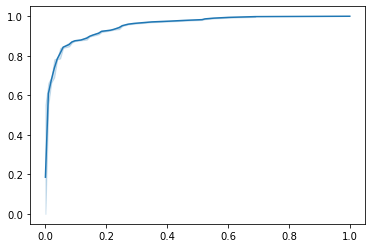

In [18]:
preds=history.valid_info["F0_preds"][0]
labels=history.valid_info["F0_labels"][0]

import sklearn.metrics as metrics
print(f"roc_auc_score:{metrics.roc_auc_score(labels,preds)}")

fpr, tpr, thresholds = metrics.roc_curve(labels,preds)
sns.lineplot(x=fpr,y=tpr)

roc_auc_score:0.9977025124138442


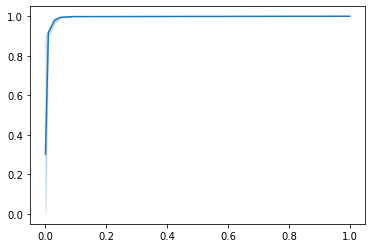

In [19]:
preds=history.valid_info["F2_preds"][9]
labels=history.valid_info["F2_labels"][9]

import sklearn.metrics as metrics
print(f"roc_auc_score:{metrics.roc_auc_score(labels,preds)}")

fpr, tpr, thresholds = metrics.roc_curve(labels,preds)
sns.lineplot(x=fpr,y=tpr)

In [78]:
import sklearn.metrics as metrics
import itertools
class ConfusionMatrix:
    def __init__(self):
        pass
    def sigmoid(x):
        return 1 / (1 +np.exp(-x))
    def get_cm(y_true,y_pred):
        cm=metrics.confusion_matrix(y_true, sigmoid(y_pred)>0.5)
        return cm.transpose()
    def plot_confusion_matrix(cm,
                            x_target_names,
                            y_target_names,
                            title='Confusion matrix',
                            cmap=None,
                            normalize=True):
 

        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        if cmap is None:
            cmap = plt.get_cmap('Blues')

        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()

        if x_target_names is not None:
            tick_marks = np.arange(len(x_target_names))
            plt.xticks(tick_marks, x_target_names, rotation=45)
        if y_target_names is not None:
            tick_marks = np.arange(len(y_target_names))
            plt.yticks(tick_marks, y_target_names, rotation=45)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


        thresh = cm.max() / 1.5 if normalize else cm.max() / 2
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")


        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel(f'Predicted label\nRecall={cm[0,0]/cm.sum(0)[0]:0.4f}; FPR={cm[0,1]/cm.sum(0)[1]:0.4f}')
        plt.show()  

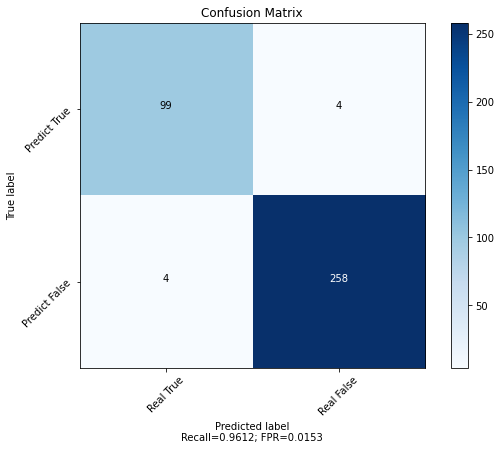

In [83]:
preds=history.valid_info["F1_preds"][9]
labels=history.valid_info["F1_labels"][9]

cm=ConfusionMatrix.get_cm(labels,preds)
ConfusionMatrix.plot_confusion_matrix(cm           = cm.transpose(), 
                      normalize    = False,
                      x_target_names = ['Real True', 'Real False'],
                      y_target_names = ['Predict True', 'Predict False'],
                      title        = "Confusion Matrix")

In [40]:
5/262

0.019083969465648856

In [52]:
["a","b"]["c"]

['a', 'b', 'c']

In [30]:
(labels==0).sum(),(labels==1).sum()

(103, 262)

In [60]:
np.Sigmoid()

AttributeError: module 'numpy' has no attribute 'Sigmoid'

In [62]:
sigmoid(np.array([-1,-0.5,0,0.5,1]))

array([0.26894142, 0.37754067, 0.5       , 0.62245933, 0.73105858])

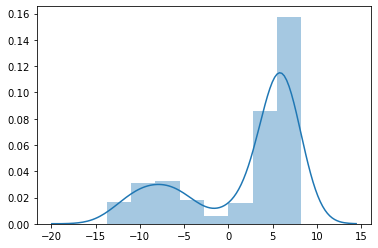

In [64]:
sns.distplot(preds)

In [40]:
import numpy as np
a=dict()
a["k1"]=[]
a["k1"].append(2)
a["k1"].append(3)

b=np.array(a)

In [42]:
np.save("npsave1.npy",b)


In [44]:
c=np.load("npsave1.npy",allow_pickle=True)

In [45]:
c

array({'k1': [2, 3]}, dtype=object)

In [46]:
b

array({'k1': [2, 3]}, dtype=object)

In [ ]:
class History:
    def __init__(self,model_name):
        self.train_info=dict()
        self.valid_info=dict()
        self.model_name=model_name
    def initial_info(self,sel_pos):
        categories=["Acc","Loss","Labels","Preds"]
        for cat in categories:
            key=f"F{sel_pos}_{cat}"
            self.train_info[key]=[]
            self.valid_info[key]=[]
    def add_train_info(self,sel_pos, train_acc,train_loss,train_labels,train_preds,valid_acc,valid_loss,valid_labels,valid_preds):
        categories=["Acc","Loss","Labels","Preds"]
        key=f"F{sel_pos}_Acc"
        self.train_info[key].append(train_acc)
        key=f"F{sel_pos}_Loss"
        self.train_info[key].append(train_loss)
        key=f"F{sel_pos}_Acc"
        self.valid_info[key].append(valid_acc)
        key=f"F{sel_pos}_Loss"
        self.valid_info[key].append(valid_loss) 
        key=f"F{sel_pos}_Labels"
        self.valid_info[key].append(valid_labels) 
        key=f"F{sel_pos}_Preds"
        self.valid_info[key].append(valid_preds) 